## Cleaning and organizing data

In [2]:
import pandas as pd

pd.set_option("display.max_rows", None)
# Load CSV

# 2021 data is separated in months so upload each of them then combine into one
df_2021_01 = pd.read_csv('subway-data-2021-01.csv')
df_2021_02 = pd.read_csv('subway-data-2021-02.csv')
df_2021_03 = pd.read_csv('subway-data-2021-03.csv')
df_2021_04 = pd.read_csv('subway-data-2021-04.csv')
df_2021_05 = pd.read_csv('subway-data-2021-05.csv')
df_2021_06 = pd.read_csv('subway-data-2021-06.csv')
df_2021_07 = pd.read_csv('subway-data-2021-07.csv')
df_2021_08 = pd.read_csv('subway-data-2021-08.csv')
df_2021_09 = pd.read_csv('subway-data-2021-09.csv')
df_2021_10 = pd.read_csv('subway-data-2021-10.csv')
df_2021_11 = pd.read_csv('subway-data-2021-11.csv')
df_2021_12 = pd.read_csv('subway-data-2021-12.csv')

df_2021 = pd.concat([df_2021_01, df_2021_02, df_2021_03, df_2021_04, df_2021_05, df_2021_06, df_2021_07, df_2021_08, df_2021_09, df_2021_10, df_2021_11, df_2021_12])
df_2023 = pd.read_csv('subway-data-2023.csv')
df_2022 = pd.read_csv('subway-data-2022.csv')
df_2024 = pd.read_csv('subway-data-2024.csv')

df = pd.concat([df_2021, df_2022, df_2023, df_2024])
df = df.dropna(subset=["Station"])


# delete SRT (discontinued line), and other unknown lines since theres so little so it won't affect the data (109 Ranee,
# Track level actitivty)
remove_lines = ["SRT", "109 RANEE", "TRACK LEVEL ACTIVITY", "YU/BD/SHP"]
df = df[~df["Line"].isin(remove_lines)]
df["Line"].value_counts()

# drop unneeded columns
df = df.drop(columns=['Code', 'Bound', 'Vehicle'])

# remove random stations or those that don't actually correspond to a normal subway station
remove_stations = ["111 SPADINA ROAD", "1900 YONGE MCBRIEN BLD", "1900 YONGE ST- MCBRIEN", "2233 SHEPPARD WEST", "ALL STATIONS", "BLOOR DANFORTH LINE", "YONGE UNIVERSITY LINE", "YONGE UNIVERSITY SUBWA", "EGLINTON STATION (MIGR", "TORONTO TRANSIT COMMIS"]
df = df[~df["Station"].isin(remove_stations)]
df = df[~df["Station"].str.contains("app|yard| to |towards", case=False)]

# rename stations with "BD" in their name to remove "BD" and any space before it
df["Station"] = df["Station"].str.replace(" BD STATION", " STATION", regex=False)
df["Station"] = df["Station"].str.replace(" YUS STATION", " STATION", regex=False)
df["Station"] = df["Station"].str.replace("ST. ", "ST ", regex=False)

# rename stations with typos and group davisville into one station (seems too statistically insignificant to drop)
df.loc[df["Station"] == "PIONEER VILLAGE STATIO", "Station"] = "PIONEER VILLAGE STATION"
df.loc[df["Station"] == "YORK UNIVERSITY STATIO", "Station"] = "YORK UNIVERSITY STATION"
df.loc[df["Station"] == "DAVISVILLE BUILD UP", "Station"] = "DAVISVILLE STATION"
df.loc[df["Station"] == "SHEPPARD STATION", "Station"] = "SHEPPARD-YONGE STATION"

# rename bloor yonge into a single station
df.loc[df["Station"] == "BLOOR STATION", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE STATION", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE-UNIVERSITY AND B", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE/UNIVERSITY AND B", "Station"] = "BLOOR-YONGE STATION"


# remove stations with fewer than 50 occurrences
station_counts = df["Station"].value_counts()
stations_to_remove = station_counts[station_counts < 50].index.tolist()
df = df[~df["Station"].isin(stations_to_remove)]
del df["Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle"]

# standardizing line names by merging slightly misspelt lines into the same name
# and deleting irrelevant or wrong-categoried 'lines' (ex. 506 carlton is a streetcar)
line_mapping = {
    "YU": "Line 1",
    "BD": "Line 2",
    "SHP": "Line 4",
    "YU/BD": "Line 1/2",
    "YU/ BD": "Line 1/2",
    "YUS/BD": "Line 1/2",
    "YUS": "Line 1",
    "YU / BD": "Line 1/2",
    "YU & BD": "Line 1/2",
    "BD/YU": "Line 1/2",
    "BD/ YU": "Line 1/2",
    "BD/ YUS": "Line 1/2",
    "SHEP": "Line 4",
    "ONGE-UNIVERSITY AND BL": "Line 1/2",
    "LINE 1": "Line 1",
    "BLOOR DANFORTH": "Line 2",
    "BD / YU": "Line 1/2",
    "YU/BD LINES": "Line 1/2",
    "YU/BD LINE": "Line 1/2",
    "YUS AND BD": "Line 1/2",
    "Y/BD": "Line 1/2",
    "B/D": "Line 2"
}

df.loc[:, "Line"] = df["Line"].replace(line_mapping)
remove_lines = ["69 WARDEN SOUTH", "LINE 2 SHUTTLE", "57 MIDLAND", "96 WILSON", "506 CARLTON", "77 SWANSEA"]
df = df[~df["Line"].isin(remove_lines)]
df["Line"].value_counts()

Line
Line 1      33000
Line 2      24618
Line 4       2262
Line 1/2      963
Name: count, dtype: int64

## Creating EDAs
### 1. Peak delay times

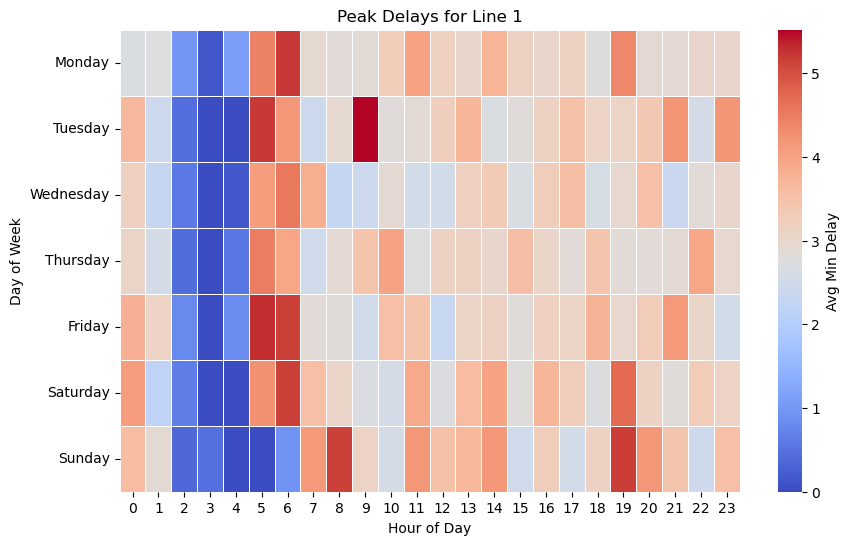

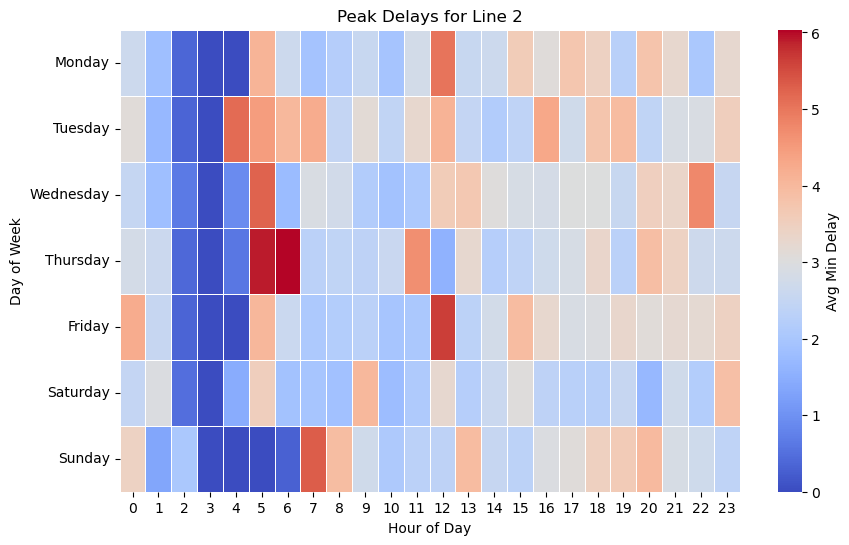

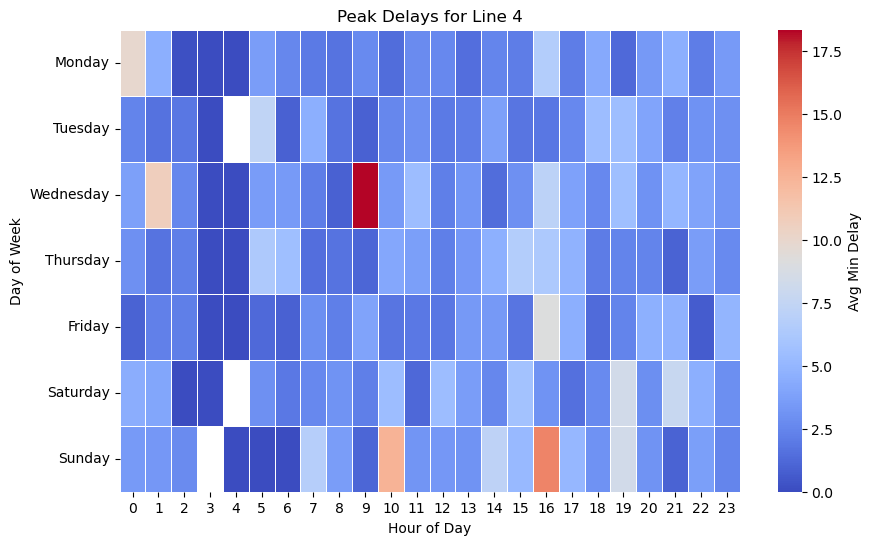

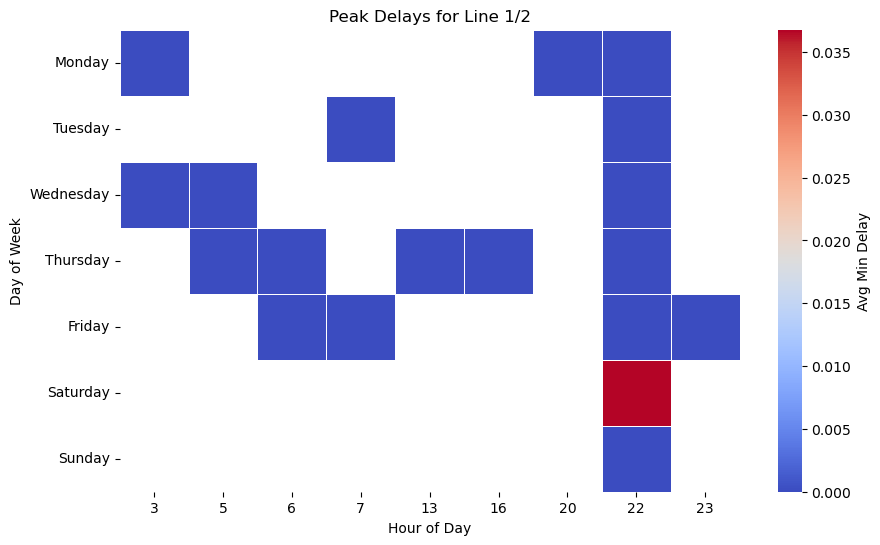

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_line1 = df[df["Line"] == "Line 1"]
df_line2 = df[df["Line"] == "Line 2"]
df_line4 = df[df["Line"] == "Line 4"]
df_line1_2 = df[df["Line"] == "Line 1/2"]

# Define correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert 'Day' column to categorical type with specified order
df["Day"] = pd.Categorical(df["Day"], categories=day_order, ordered=True)

# Sort by day to ensure the order is correct
df = df.sort_values("Day")

def plot_heatmap(df, line_name):
    # Convert Time to hourly bins
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M").dt.hour  # Extract only hour
    
    # Pivot table (index = Day, columns = Hour, values = Avg Min Delay)
    heatmap_data = df.pivot_table(index="Day", columns="Time", values="Min Delay", aggfunc="mean")

    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, linewidths=0.5, cbar_kws={'label': 'Avg Min Delay'})
    plt.title(f"Peak Delays for Line {line_name}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()

# Plot heatmaps for each line
plot_heatmap(df_line1, "1")
plot_heatmap(df_line2, "2")
plot_heatmap(df_line4, "4")
plot_heatmap(df_line1_2, "1/2")

# don't include line 1/2 into report as there's not enough data for every hour
# and in general to make any insightful conclusions or hypotheses

## 3. Frequency of delays

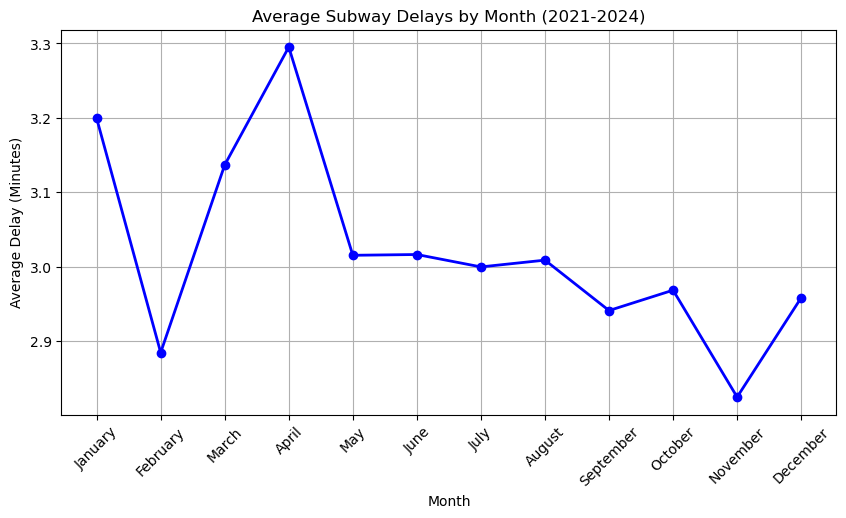

In [17]:
# Line chart

# Convert 'Date' column to datetime format if not already
df["Date"] = pd.to_datetime(df["Date"])

# Extract the month names
df["Month"] = df["Date"].dt.strftime("%B")  # 'January', 'February', etc.

# Compute the average delay for each month across all years
monthly_avg_delays = df.groupby("Month")["Min Delay"].mean()

# Sort by calendar order instead of alphabetical order
month_order = ["January", "February", "March", "April", "May", "June", "July", 
               "August", "September", "October", "November", "December"]
monthly_avg_delays = monthly_avg_delays.reindex(month_order)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_delays.index, monthly_avg_delays.values, marker="o", linestyle="-", color="blue", linewidth=2)

# Format the plot
plt.xlabel("Month")
plt.ylabel("Average Delay (Minutes)")
plt.title("Average Subway Delays by Month (2021-2024)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(True)

# Show the plot
plt.show()
